## Import required packages 

In [1]:
import pandas as pd 
import numpy as np

import requests

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error

import logging
import sys

from prophet import Prophet

%matplotlib inline

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extract stock prices for each 

In [2]:
def get_stock_prices(api_key, tckr ): 
    '''
    Input 
    api_key - unique key from polgon.io that you get for signin up
    tckr - the stock that values need to be extracted 

    Ouput 
    df - volume, price, open, close, high and low stock prices for the stock for each day for the previous 2 years 
         (2 years is the maxiumum time span for the free trial of polygon.io )
    '''
    url = f'https://api.polygon.io/v2/aggs/ticker/{tckr}/range/1/day/2023-01-19/2025-01-19?apiKey={api_key}'
    
    response = requests.get(url)
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df = pd.DataFrame(data['results'])
    
    # Convert the timestamp to a readable date format
    df['t'] = pd.to_datetime(df['t'], unit='ms')
    
    # Display the historical data
    return df

In [3]:
api_key = 'BIf89HTb0NaGQsWozgDr5x1W8GfFC3MH'
# Choose 4 stores that are closest competitors as we can only download 5 a min with the free API 
stocks = ['GLW','APH','DLB','LFUS','ROG']

stock_prices_df = pd.DataFrame([])

for tckr in stocks:
    stock_prices_df_pre = get_stock_prices(api_key, tckr)
    stock_prices_df_pre.columns = [f"{col}_{tckr}" if col != 't' else col for col in stock_prices_df_pre.columns]
    if stock_prices_df.empty:
        stock_prices_df = stock_prices_df_pre
    else:
        stock_prices_df = stock_prices_df.merge(stock_prices_df_pre, on='t', how='outer')

pred_stock = 'o_GLW'

In [4]:
stock_prices_df.head()

,v_GLW,vw_GLW,o_GLW,c_GLW,h_GLW,l_GLW,t,n_GLW,v_APH,vw_APH,...,h_LFUS,l_LFUS,n_LFUS,v_ROG,vw_ROG,o_ROG,c_ROG,h_ROG,l_ROG,n_ROG
0,4334809.0,35.4321,35.49,35.56,35.64,35.025,2023-01-25 05:00:00,39349,7761076.0,39.1836,...,251.7100,246.31,3401,296371.0,131.9778,130.00,133.60,134.470,129.36,5950
1,4777904.0,36.2280,35.72,36.43,36.44,35.720,2023-01-26 05:00:00,51171,5834620.0,39.1989,...,254.1300,246.50,4826,228450.0,134.5502,133.45,135.36,135.410,132.90,4868
2,4588693.0,36.8311,36.33,36.80,37.04,36.295,2023-01-27 05:00:00,41879,5188690.0,39.2769,...,256.3700,250.20,3688,178757.0,135.9170,134.76,136.57,136.570,134.76,5286
3,6646356.0,36.6320,36.62,36.39,37.10,36.330,2023-01-30 05:00:00,50764,3428662.0,39.1818,...,251.8999,246.27,3356,253643.0,136.4623,135.24,137.19,137.295,135.04,6072
4,14063381.0,34.7587,36.39,34.61,36.39,34.420,2023-01-31 05:00:00,85245,3985268.0,39.6540,...,257.4400,246.75,4304,292621.0,139.0927,137.02,139.59,140.820,136.00,6958


## See if any data is missing 

In [5]:
stock_prices_df.isna().sum().sum()

np.int64(0)

In [6]:
stock_prices_df.isin([np.inf, -np.inf]).sum().sum()

np.int64(0)

In [7]:
# No missing data, all has been pulled through from the API 

## Explore the data 

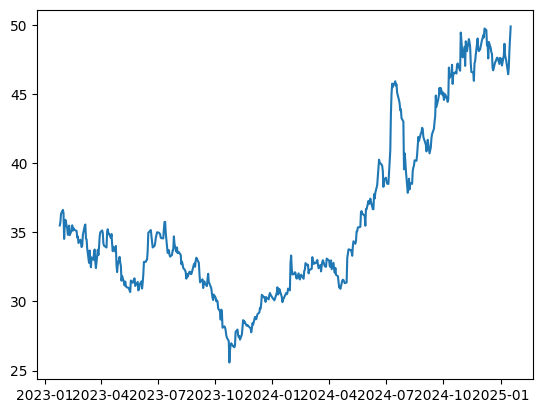

In [8]:
# look at trend over time 
plt.plot(stock_prices_df['t'],stock_prices_df[pred_stock])

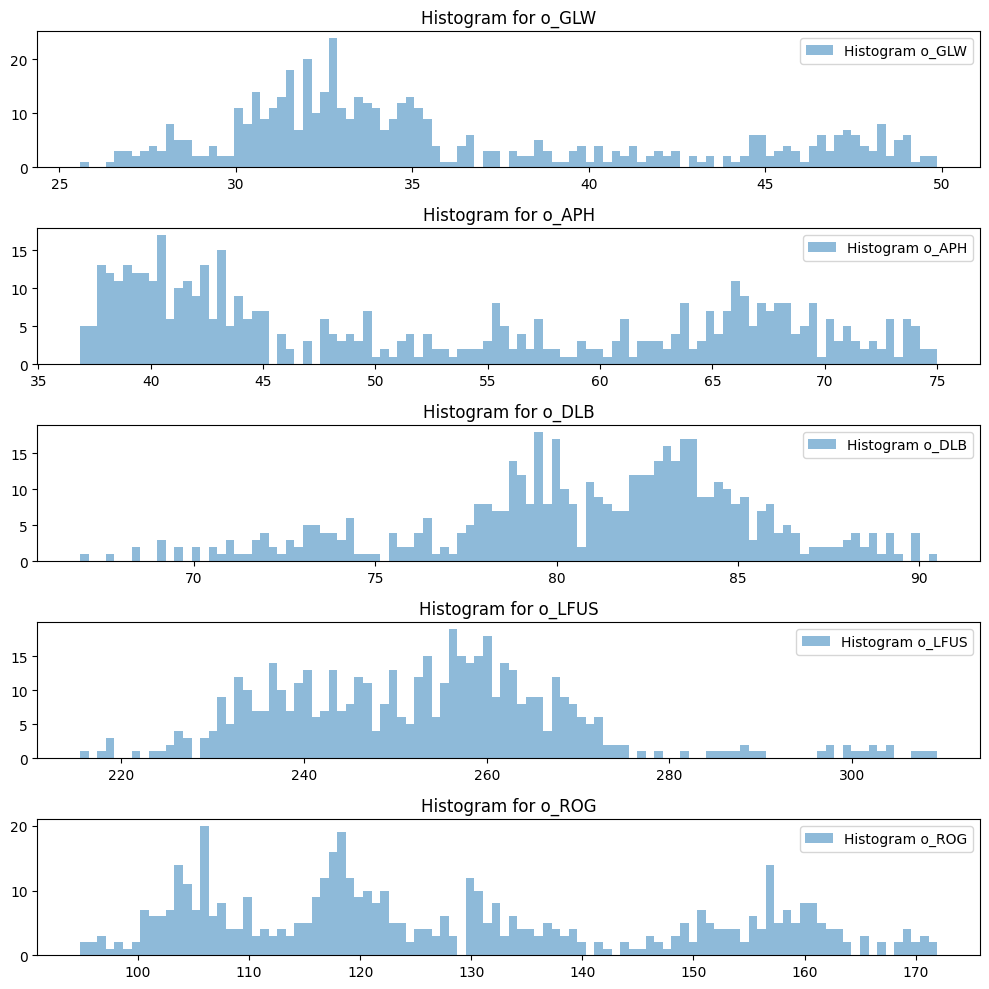

In [9]:
# Most stocks are not normally distributed so make sure methods do not include this 
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i, tckr in enumerate(stocks[:5]):
    tckr = 'o_' + tckr 
    axs[i].hist(stock_prices_df[tckr], bins=100, alpha=0.5, label=f'Histogram {tckr}')
    axs[i].set_title(f'Histogram for {tckr}')
    axs[i].legend()

plt.tight_layout()
plt.show()

## Auto regression 
Understand if previous values in previous time series contribute to fucture 

In [10]:
def autocorrelation_check(df, target_col, col, min_lag=5, max_lag=50):
    correlations = []
    lagged_cols = {}
    for lag in range(min_lag, max_lag + 1):
        lagged_cols[f'{col}_lagged_{lag}'] = df[col].shift(lag)
    
    lagged_df = pd.DataFrame(lagged_cols)
    target_series = df[target_col]
    
    for lag in range(min_lag, max_lag + 1):
        correlation = target_series.corr(lagged_df[f'{col}_lagged_{lag}'])
        correlations.append({'lag': lag, 'correlation': correlation})
    
    correlation_df = pd.DataFrame(correlations)
    return correlation_df

def generate_top_correlations(df, target_col=pred_stock, min_lag=5, max_lag=6):
    all_correlations = []
    for col in df.columns:
        if col == 't':
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        correlation_df['column'] = col
        all_correlations.append(correlation_df)
    
    all_correlations_df = pd.concat(all_correlations)
    
    # Get the top one correlation from each column by magnitude
    top_correlations = all_correlations_df.loc[all_correlations_df.groupby('column')['correlation'].apply(lambda x: x.abs().idxmax())]
    
    # Select only the relevant columns
    top_correlations = top_correlations[['column', 'lag', 'correlation']]
    
    return top_correlations

In [11]:
top_corr_columns = generate_top_correlations(stock_prices_df,max_lag = 28 * 6)

In [12]:
def plot_correlations(df, target_col=pred_stock, min_lag=5, max_lag=50):
    for col in df.columns:
        if col == 't' :
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        plt.figure(figsize=(10, 1))
        plt.plot(correlation_df['lag'], correlation_df['correlation'], marker='o')
        plt.title(f'Lag vs Correlation for {col}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.grid(True)
        plt.show()

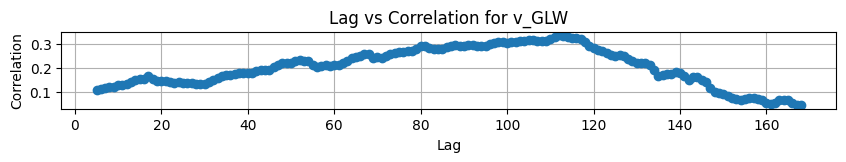

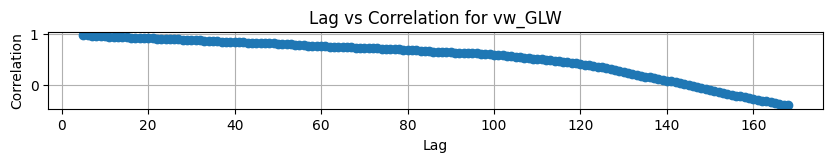

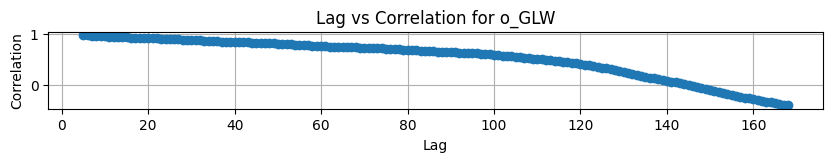

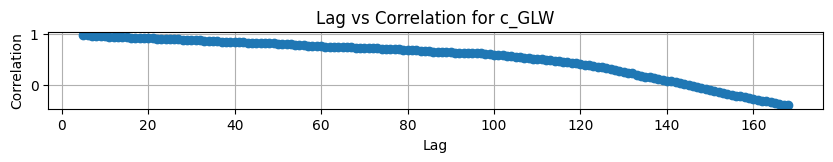

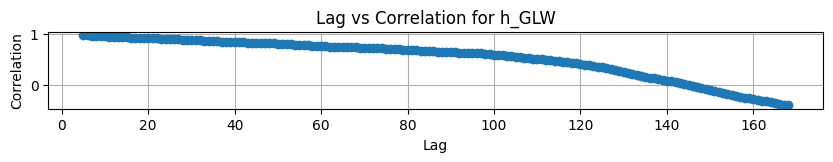

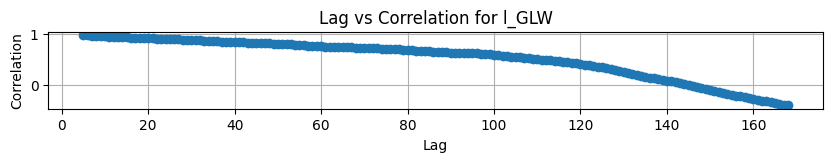

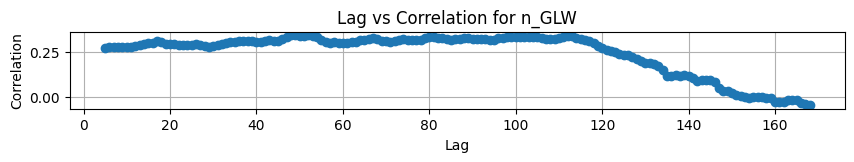

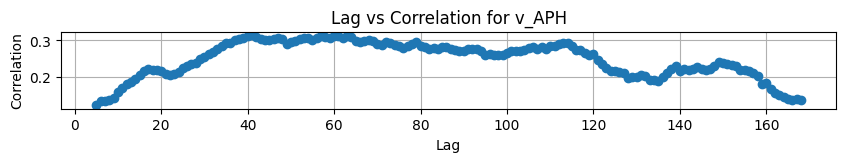

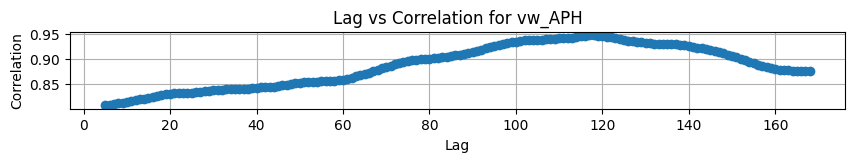

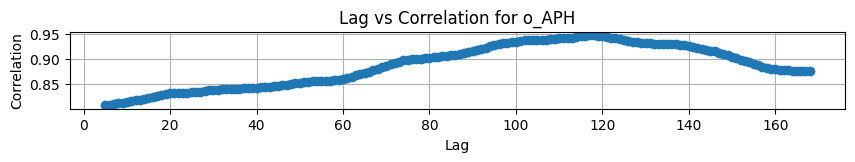

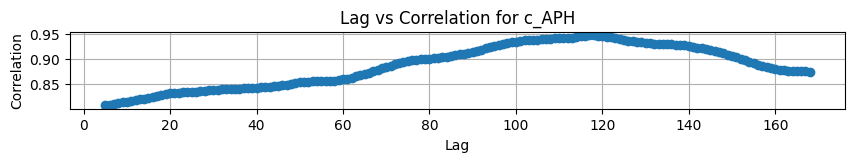

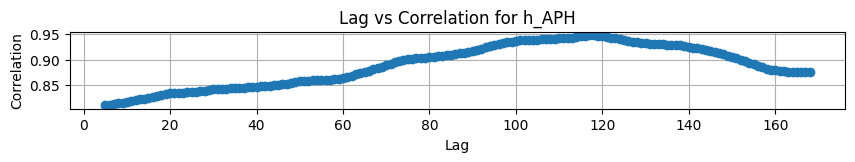

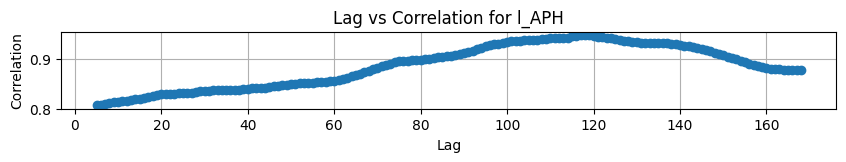

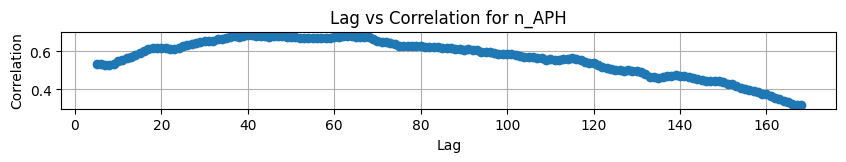

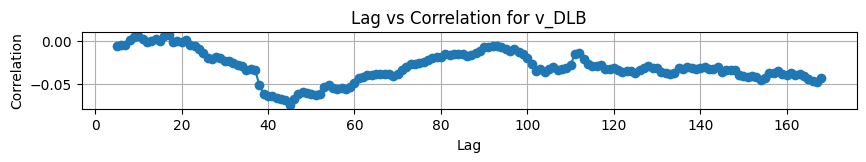

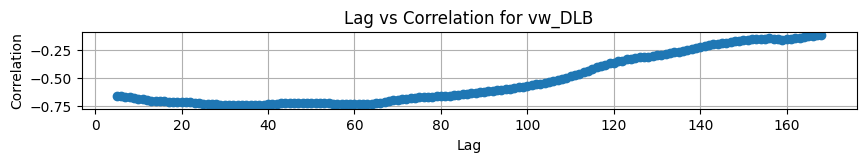

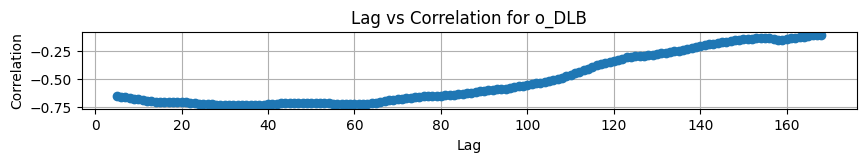

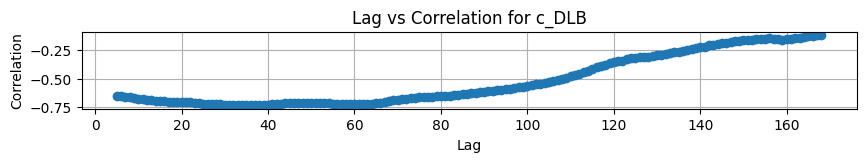

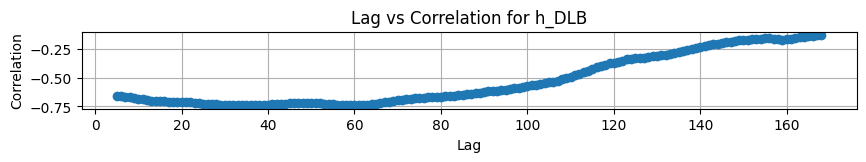

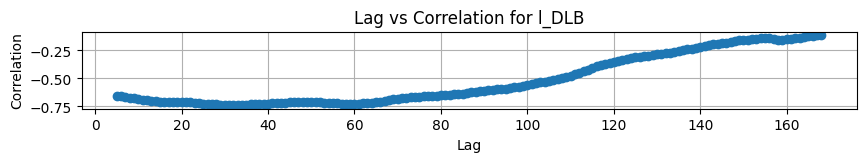

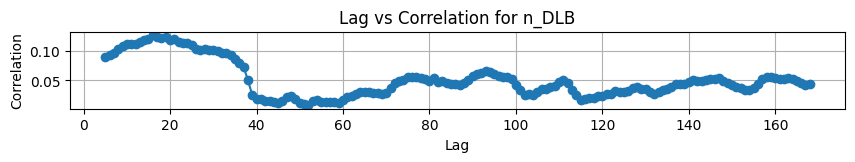

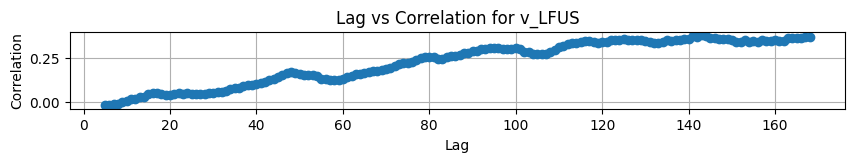

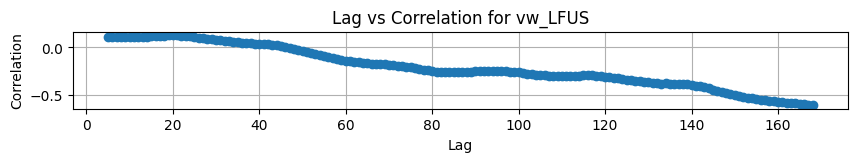

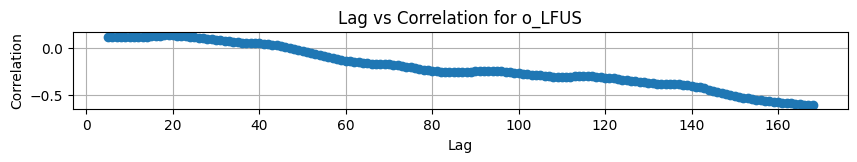

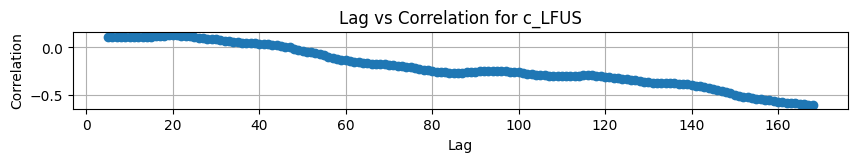

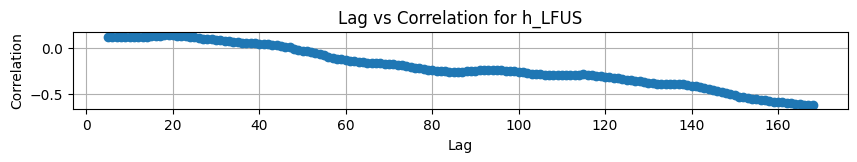

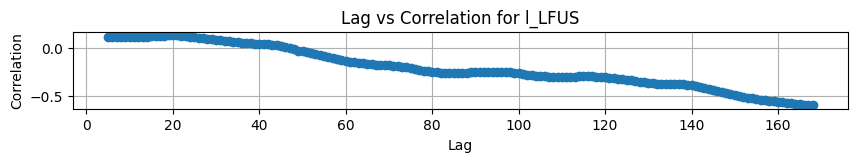

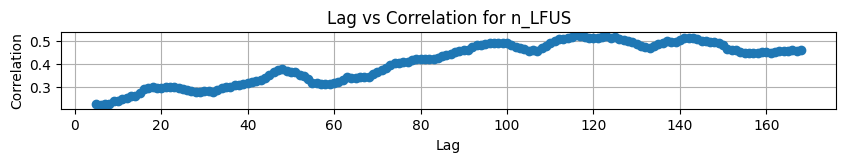

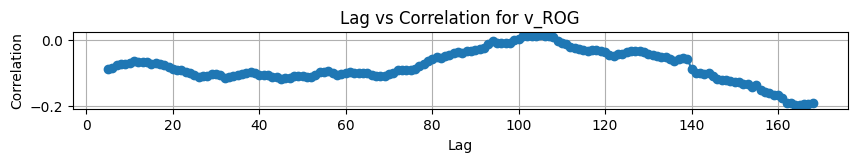

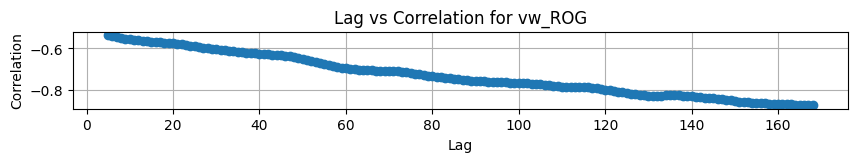

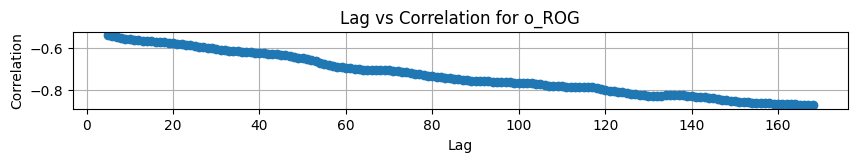

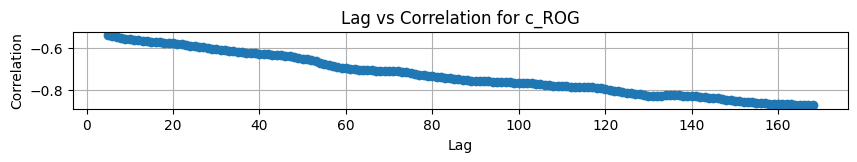

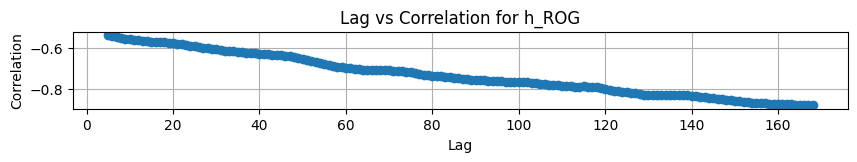

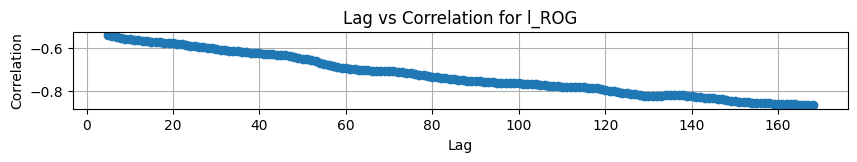

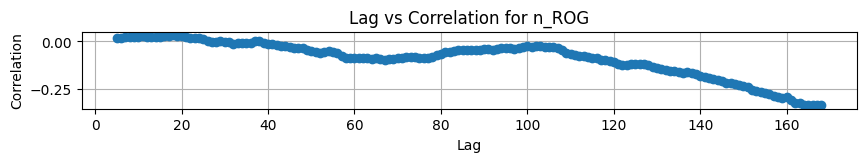

In [13]:
# Only a few double peaks so maxiumum can be used
plot_correlations(stock_prices_df,max_lag = 28 * 6)

In [14]:
top_corr_columns

,column,lag,correlation
112,v_GLW,117,0.318011
112,vw_GLW,117,0.446815
112,o_GLW,117,0.444138
112,c_GLW,117,0.448842
112,h_GLW,117,0.443464
...,...,...,...
163,o_ROG,168,-0.871601
163,c_ROG,168,-0.873258
163,h_ROG,168,-0.877497
163,l_ROG,168,-0.868495


In [15]:
lagged_df = pd.DataFrame()

for index, row in top_corr_columns.iterrows():
    column_name = row['column']
    lag_amount = row['lag']
    
    # Shift the column by the specified lag amount
    lagged_column = stock_prices_df[column_name].shift(lag_amount)
    
    # Add the lagged column to the new dataframe
    lagged_df[column_name] = lagged_column

# Drop rows with NaN values resulting from the lagging process
lagged_df.dropna(inplace=True)

In [16]:
# 99% of autocorrelation variation done by 2 previous columns 
pca = PCA(n_components=0.99)
pca_result = pca.fit_transform(lagged_df)

# Convert PCA result to a dataframe
pca_df = pd.DataFrame(pca_result)

In [17]:
# Ensure the indices match for concatenation
pca_df.index = lagged_df.index

# Add the PCA columns to the original stock_prices_df
for i in range(pca_df.shape[1]):
    stock_prices_df[f"PCA_{i+1}"] = pca_df.iloc[:, i]

# Print the updated dataframe
stock_prices_df.tail(5)

,v_GLW,vw_GLW,o_GLW,c_GLW,h_GLW,l_GLW,t,n_GLW,v_APH,vw_APH,...,v_ROG,vw_ROG,o_ROG,c_ROG,h_ROG,l_ROG,n_ROG,PCA_1,PCA_2,PCA_3
493,4455826.0,46.5000,46.42,46.58,46.870,46.19,2025-01-13 05:00:00,48541,6586630.0,68.0865,...,144255.0,94.9591,94.80,94.78,95.8599,94.160,4581,-1.558798e+06,-6.203986e+05,-142213.304397
494,2903878.0,47.2820,46.90,47.43,47.550,46.86,2025-01-14 05:00:00,33925,6049402.0,69.9137,...,94189.0,94.7888,94.87,95.01,95.9250,93.810,4089,-2.029625e+06,-8.140538e+05,-146925.287019
495,4007155.0,48.7258,48.18,48.81,48.905,48.16,2025-01-15 05:00:00,40004,5706414.0,71.1775,...,83348.0,96.1841,97.03,95.92,97.2950,95.500,3685,1.154193e+06,2.059964e+06,98131.883310
496,2911877.0,49.1218,49.09,49.24,49.310,48.80,2025-01-16 05:00:00,34096,6187837.0,70.1712,...,71010.0,95.5376,95.60,95.68,96.1250,94.480,3743,5.169543e+05,-2.088027e+06,-105027.593784
497,5317767.0,49.9373,49.87,49.84,50.320,49.50,2025-01-17 05:00:00,48962,9048893.0,69.4403,...,92750.0,96.1187,96.78,95.77,97.2000,95.315,3926,2.000422e+06,-1.743663e+06,15660.797161


## Excluded Standerd deviation
Later on it may be beneficial to exclude large fluctuation in stock 

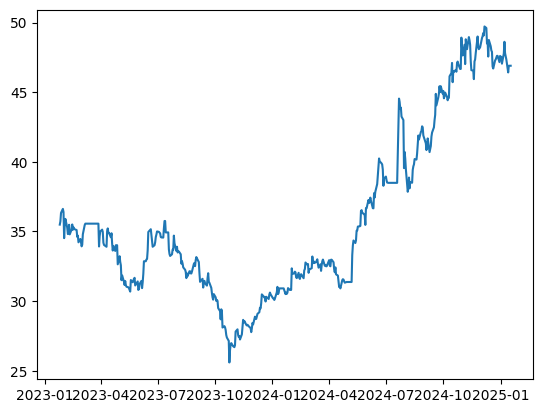

In [18]:
# Predicting 5 days into the future so use rolling 5 days standerd deviation 
stock_prices_df[pred_stock + '_std'] =  stock_prices_df[pred_stock].rolling(window=20).std()

# Initialize the last valid value
last_valid_value = stock_prices_df.loc[0, 'o_GLW']

# Create a new column 'o_GLW_no_dev' and copy the original 'o_GLW' values
stock_prices_df['o_GLW_no_dev'] = stock_prices_df['o_GLW']

# Forward fill the previous stock price when the magnitude of the deviation is greater than a threshold
for i in range(1, len(stock_prices_df)):
    threshold = 2 * stock_prices_df.loc[i, 'o_GLW_std']  # Update threshold based on the most recent std
    if abs(stock_prices_df.loc[i, 'o_GLW'] - last_valid_value) > threshold:
        stock_prices_df.loc[i, 'o_GLW_no_dev'] = last_valid_value
    else:
        last_valid_value = stock_prices_df.loc[i, 'o_GLW']

plt.plot(stock_prices_df['t'] ,stock_prices_df['o_GLW_no_dev'])

In [19]:
# Changed to function so can possibly be implemented in the end to improve accuracy 
def remove_deviation(stock_prices_df, target_column):
    # Calculate rolling standard deviation
    stock_prices_df[target_column + '_std'] = stock_prices_df[target_column].rolling(window=10).std()

    # Initialize the last valid value
    last_valid_value = stock_prices_df.loc[0, target_column]

    # Create a new column for the adjusted values
    adjusted_column = target_column + '_no_dev'
    stock_prices_df[adjusted_column] = stock_prices_df[target_column]

    # Forward fill the previous stock price when the magnitude of the deviation is greater than a threshold
    for i in range(1, len(stock_prices_df)):
        threshold = 2 * stock_prices_df.loc[i-1, target_column + '_std']  # Update threshold based on the most recent std
        if abs(stock_prices_df.loc[i, target_column] - last_valid_value) > threshold:
            stock_prices_df.loc[i, adjusted_column] = last_valid_value
        else:
            last_valid_value = stock_prices_df.loc[i, target_column]

    return stock_prices_df

## Pct changes 

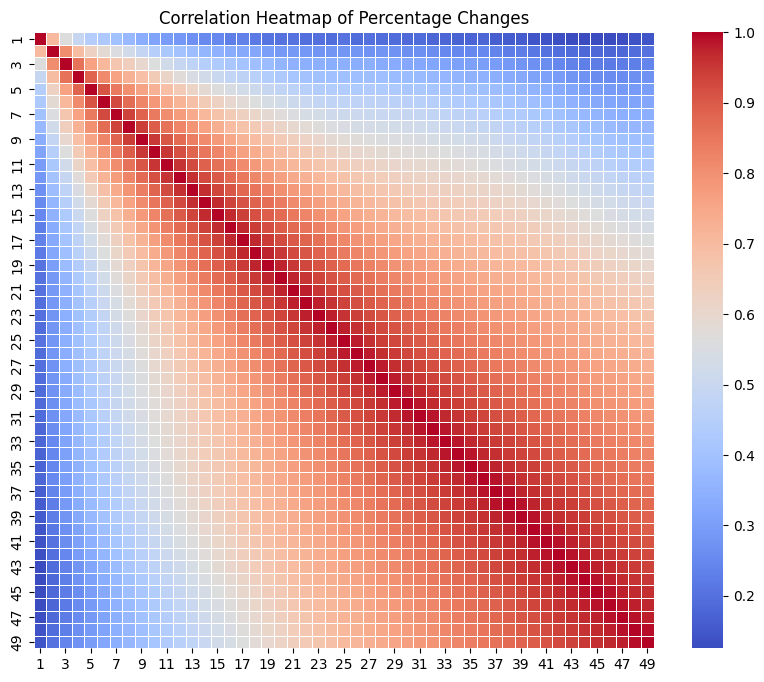

In [47]:
# Create the correlation matrix of percentage changes
pct_change_corr_df = pd.DataFrame([])

for i in range(1, 50):
    pct_change_df = pd.DataFrame(stock_prices_df[pred_stock].pct_change(-i))
    pct_change_df.columns = [str(i)]
    pct_change_corr_df = pd.concat([pct_change_corr_df, pct_change_df], axis=1)

corr_matrix = pct_change_corr_df.corr()

# Generate a heatmap with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Percentage Changes')
plt.show()

In [56]:
# Introduce on the most recent pct changes to the data
# We start to see very low correlations after 20 days to this will be the max 

def pct_change(df,target_col):
    '''
    Input 
    df - Stock dataframe
    target_col - target column you wish to get pct changes from

    Ouput
    df - original data frame with pct changes for 1,5,10 and 20 days 

    '''

    df[target_col + '_1_day_pct_chng'] = df[target_col].pct_change(-1)
    df[target_col + '_5_day_pct_chng'] = df[target_col].pct_change(-5)
    df[target_col + '_10_day_pct_chng'] = df[target_col].pct_change(-10)
    df[target_col + '_20_day_pct_chng'] = df[target_col].pct_change(-20)

    return df

## Loss aversion 
- Works on the percent change to identify the fact that dips in stock price are seen as worse than gains 
- We can also work this into the activation function later to try and see if buyers are averting loss 

In [57]:
def loss_aversion_change(df, target_col):
    '''
    Input 
    df - Stock dataframe
    target_col - target column you wish to get pct changes from

    Ouput
    df - original data frame with the loss aversion function equation applied 

    '''

    def loss_aversion_function(x, alpha=0.88, beta=0.88, lambda_=2.5):
        if x >= 0:
            return x ** alpha
        else:
            return -lambda_ * (-x) ** beta
    
    df['loss_averse_' + target_col] = df[target_col].apply(lambda x: loss_aversion_function(x))

    return df

## Moving averages and time series analysis

### Moving Average 

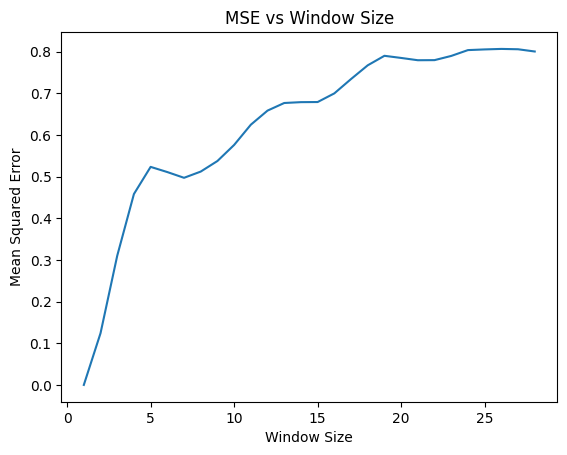

In [21]:
# Moving average dips at 7 with minimal mse so we can use this 

# Function to calculate moving average and mean squared error
def calculate_mse(df, window, prediction_days):
    df = df.copy()  # Avoid modifying the original DataFrame
    df['moving_average'] = df[pred_stock].rolling(window=window).mean()
    mse_list = []
    
    for i in range(len(df) - window - prediction_days + 1):
        actual = df[pred_stock][i + window:i + window + prediction_days].values
        predicted = df['moving_average'][i + window:i + window + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

# Iterate over all windows up to 28 days and predict 5 days in the future
results = []

for window in range(1, 29):
    mse_list = []
    for start_day in range(len(stock_prices_df) - window - 30, len(stock_prices_df) - window - 5):
        mse = calculate_mse(stock_prices_df.iloc[start_day:], window, 5)
        mse_list.append(mse)
    avg_mse = np.mean(mse_list)
    results.append({'window': window, 'mse': avg_mse})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Plot the results
plt.plot(results_df['window'], results_df['mse'])
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Window Size')
plt.show()


### Exponential moving average 

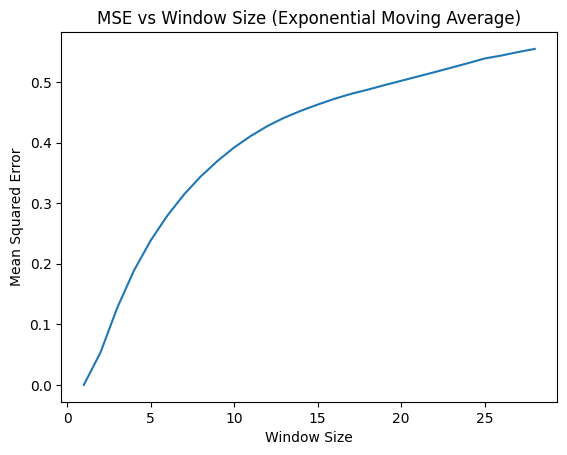

In [22]:
# Far better for exponantial moving average and 2 days is the best one (7 can be used)

# Function to calculate exponential moving average and mean squared error
def calculate_ema_mse(df, window, prediction_days):
    df = df.copy()  # Avoid modifying the original DataFrame
    df['exponential_moving_average'] = df[pred_stock].ewm(span=window, adjust=False).mean()
    mse_list = []
    
    for i in range(len(df) - window - prediction_days + 1):
        actual = df[pred_stock][i + window:i + window + prediction_days].values
        predicted = df['exponential_moving_average'][i + window:i + window + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

# Iterate over all windows up to 28 days and predict 5 days in the future, excluding the last 5 days
results = []

for window in range(1, 29):
    mse_list = []
    for start_day in range(len(stock_prices_df) - window - 30, len(stock_prices_df) - window - 10):  # Exclude the last 5 days
        mse = calculate_ema_mse(stock_prices_df.iloc[start_day:], window, 5)
        mse_list.append(mse)
    avg_mse = np.mean(mse_list)
    results.append({'window': window, 'mse': avg_mse})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Plot the results
plt.plot(results_df['window'], results_df['mse'])
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Window Size (Exponential Moving Average)')
plt.show()

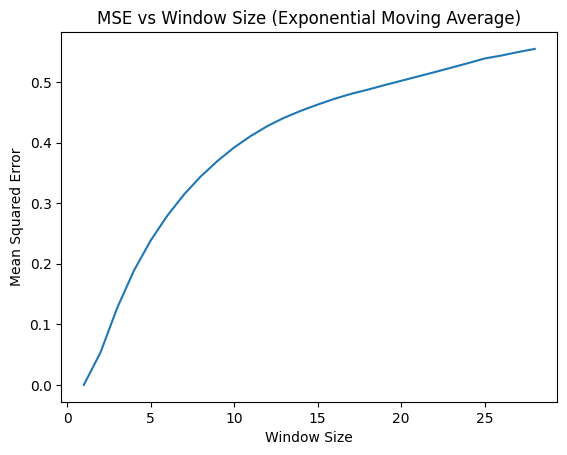

In [23]:
# Far better for exponantial moving average and 2 days is the best one (7 can be used)

# Function to calculate exponential moving average and mean squared error
def calculate_ema_mse(df, window, prediction_days):
    df = df.copy()  # Avoid modifying the original DataFrame
    df['exponential_moving_average'] = df[pred_stock].ewm(span=window, adjust=False).mean()
    mse_list = []
    
    for i in range(len(df) - window - prediction_days + 1):
        actual = df[pred_stock][i + window:i + window + prediction_days].values
        predicted = df['exponential_moving_average'][i + window:i + window + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

# Iterate over all windows up to 28 days and predict 5 days in the future, excluding the last 5 days
results = []

for window in range(1, 29):
    mse_list = []
    for start_day in range(len(stock_prices_df) - window - 30, len(stock_prices_df) - window - 10):  # Exclude the last 5 days
        mse = calculate_ema_mse(stock_prices_df.iloc[start_day:], window, 5)
        mse_list.append(mse)
    avg_mse = np.mean(mse_list)
    results.append({'window': window, 'mse': avg_mse})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Plot the results
plt.plot(results_df['window'], results_df['mse'])
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Window Size (Exponential Moving Average)')
plt.show()

### Prophet

In [24]:
# Suppress cmdstanpy INFO messages
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Suppress Prophet INFO messages
logging.getLogger('prophet').setLevel(logging.ERROR)

# Suppress other related INFO messages
logging.getLogger('fbprophet').setLevel(logging.ERROR)

# Function to calculate mean squared error using Prophet
def calculate_mse_prophet(df, prediction_days):
    df = df.copy()  # Avoid modifying the original DataFrame
    df['y'] = df[pred_stock]
    df['ds'] = df['t']
    
    # Fit the model
    model = Prophet()
    model.fit(df[['ds', 'y']])
    
    # Make future dataframe
    future = model.make_future_dataframe(periods=prediction_days)
    
    # Predict
    forecast = model.predict(future)
    
    mse_list = []
    
    for i in range(len(df) - prediction_days + 1):
        actual = df[pred_stock][i:i + prediction_days].values
        predicted = forecast['yhat'][i:i + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

# Iterate over all windows up to 28 days and predict 5 days in the future, excluding the last 5 days
results = []

for window in range(1, 29):
    mse_list = []
    for start_day in range(len(stock_prices_df) - window - 30, len(stock_prices_df) - window - 10):  # Exclude the last 5 days
        mse = calculate_mse_prophet(stock_prices_df.iloc[start_day:], 5)
        mse_list.append(mse)
    avg_mse = np.mean(mse_list)
    results.append({'window': window, 'mse': avg_mse})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Plot the results
plt.plot(results_df['window'], results_df['mse'])
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Window Size (Prophet Prediction)')
plt.show()

12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:59 - cmdstanpy - INFO - Chain [1] done processing
12:33:59 - cmdstanpy - INFO - Chain [1] start processing
12:33:59 - cmdstanpy - INFO - Chain [1] done processing
12:33:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

# Model out changes over time 

## References 
- https://polygon.io/ - used to pull in stock prices 
- https://www.marketbeat.com/stocks/NYSE/GLW/competitors-and-alternatives/#:~:text=The%20main%20competitors%20of%20Corning,%2C%20and%20ARM%20(ARM). - Corning competitors